In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [24]:
from imblearn.over_sampling import SMOTE

In [51]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, auc, f1_score, plot_roc_curve

## Load data

In [2]:
raw_dataset = pd.read_csv("../Data/car.data",
                          names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

In [3]:
raw_dataset.tail()

buying maint  doors persons lug_boot safety  class
1723    low   low  5more    more      med    med   good
1724    low   low  5more    more      med   high  vgood
1725    low   low  5more    more      big    low  unacc
1726    low   low  5more    more      big    med   good
1727    low   low  5more    more      big   high  vgood

__Data Dict__
 - buying (Buying price of the car \[v-high, high, med, low\])
 - maint (Price of the maintenance of car \[v-high, high, med, low\])
 - doors (Number of doors \[2, 3, 4, 5, more\])
 - persons (Capacity in terms of persons to carry \[2, 4, more\])
 - lug_boot (The size of luggage boot \[small, med, big\])
 - safety (Estimate safety of the car \[low, med, high\])
 - class (Car acceptability \[unacc: unacceptible, acc: acceptible, good: good, v-good: very good\])

In [4]:
dataset = raw_dataset.copy()

## EDA

### Data type

In [5]:
dataset.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

### Count the non-missing value

In [6]:
dataset.count()

buying      1728
maint       1728
doors       1728
persons     1728
lug_boot    1728
safety      1728
class       1728
dtype: int64

### Descriptive statistic

In [7]:
dataset.describe(include='all').T

count unique    top  freq
buying    1728      4  vhigh   432
maint     1728      4  vhigh   432
doors     1728      4      2   432
persons   1728      3      2   576
lug_boot  1728      3  small   576
safety    1728      3    low   576
class     1728      4  unacc  1210

### Categorical distribution

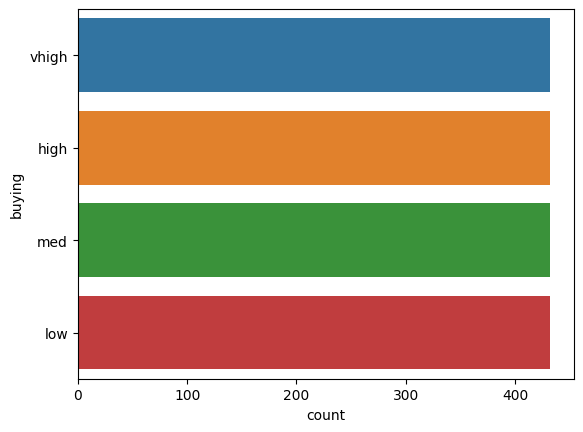

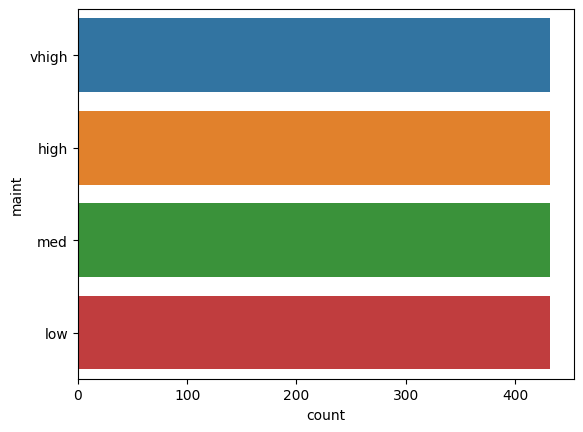

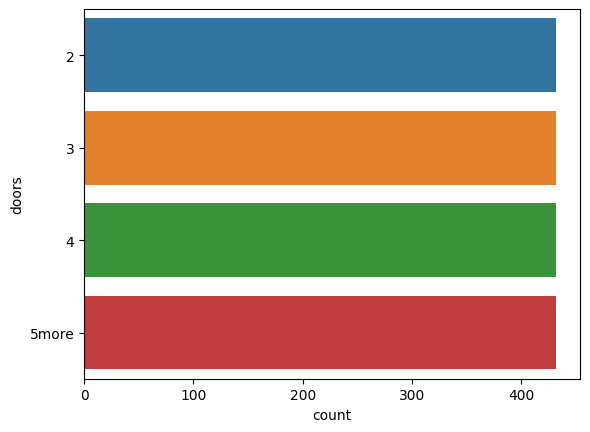

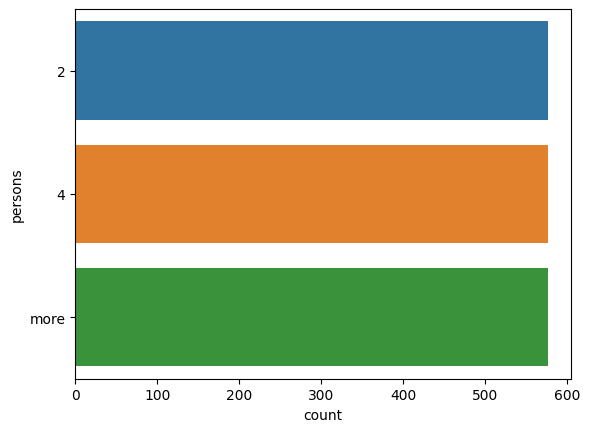

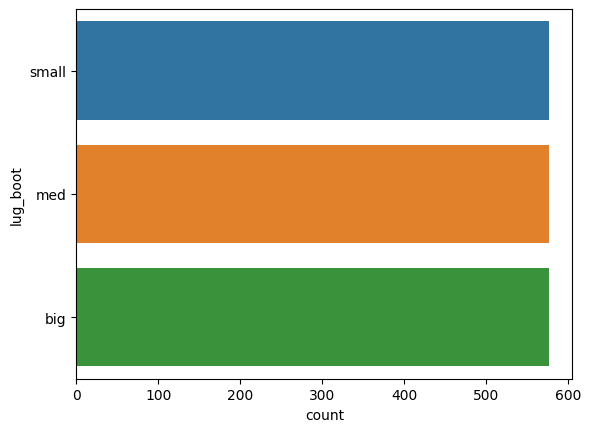

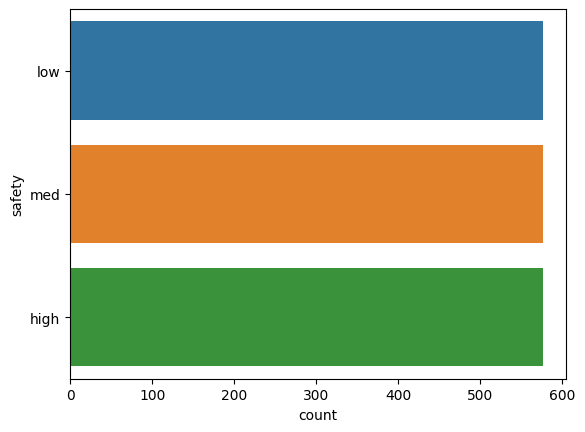

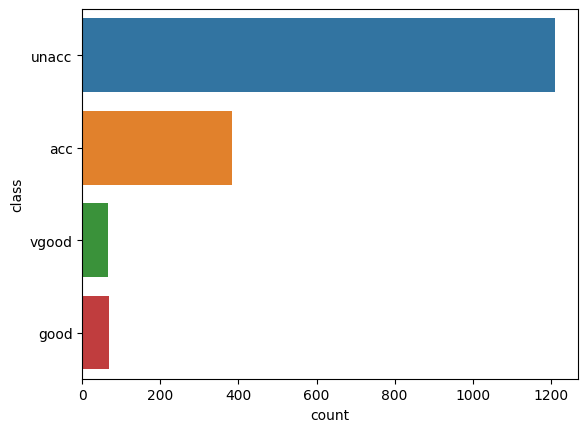

In [8]:
for col in dataset.select_dtypes('object'):
    sns.countplot(y=col, data=dataset)
    plt.show()

The coutplot graph show an imbalanced class dataset. Thus, we need to upsampling or downsampling to handle this issue.

### Segment and group the target feature

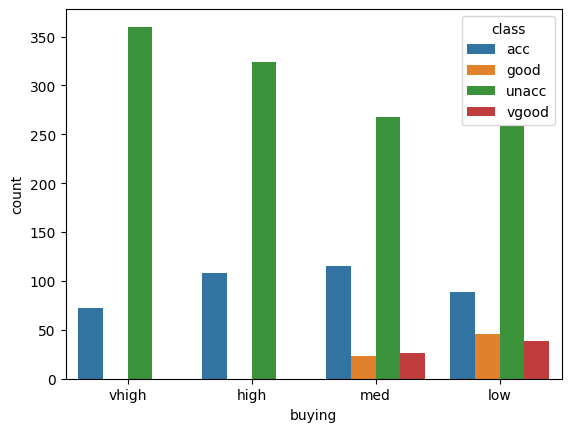

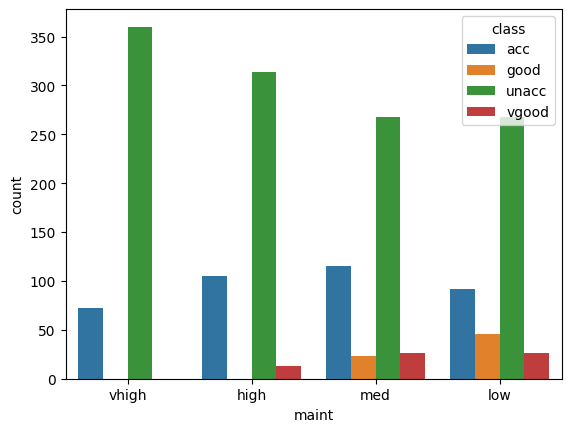

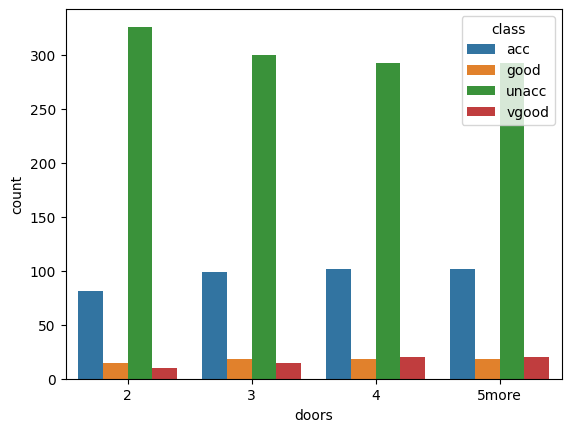

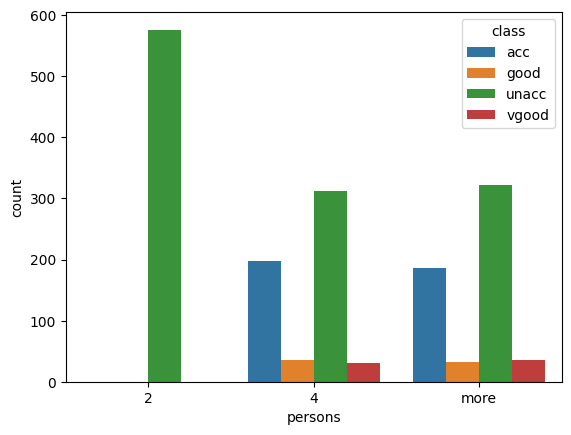

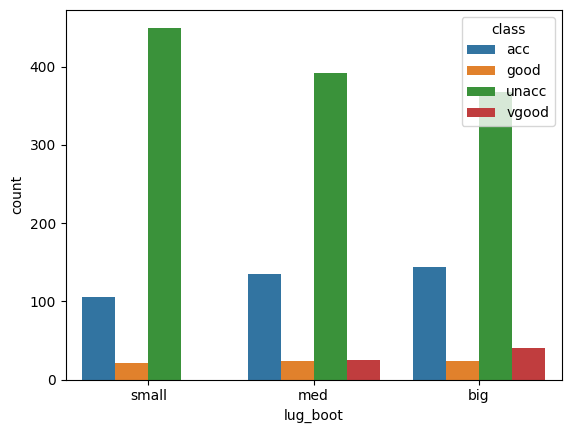

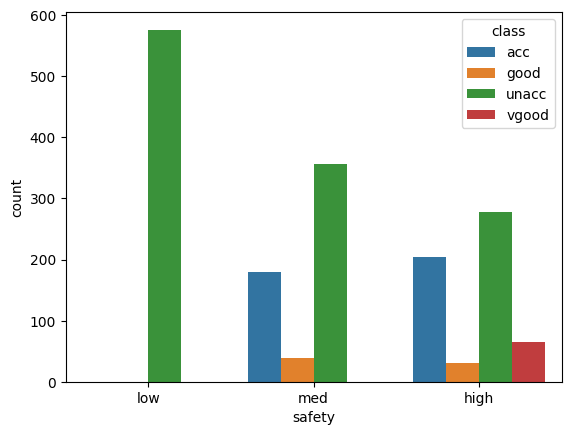

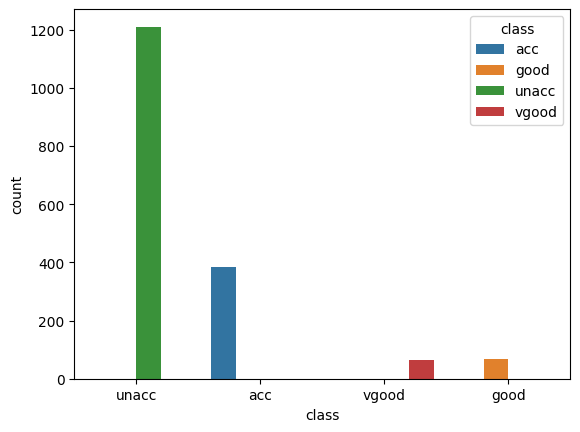

In [15]:
for col in dataset.select_dtypes('object'):
    sns.countplot(x = col,
                 hue = dataset['class'].astype('category'),
                 data=dataset)
    plt.show()

## Preprocessing

### Get dummy data

In [19]:
label = dataset['class']
dataset = pd.get_dummies(dataset.drop(columns='class'))
dataset['class'] = label

In [20]:
dataset.tail()

buying_high  buying_low  buying_med  buying_vhigh  maint_high  \
1723            0           1           0             0           0   
1724            0           1           0             0           0   
1725            0           1           0             0           0   
1726            0           1           0             0           0   
1727            0           1           0             0           0   

      maint_low  maint_med  maint_vhigh  doors_2  doors_3  ...  persons_2  \
1723          1          0            0        0        0  ...          0   
1724          1          0            0        0        0  ...          0   
1725          1          0            0        0        0  ...          0   
1726          1          0            0        0        0  ...          0   
1727          1          0            0        0        0  ...          0   

      persons_4  persons_more  lug_boot_big  lug_boot_med  lug_boot_small  \
1723          0             1             0             1               0   
1724          0             1             0             1               0   
1725          0             1             1             0               0   
1726          0             1             1             0               0   
1727          0             1             1             0               0   

      safety_high  safety_low  safety_med  class  
1723            0           0           1   good  
1724            1           0           0  vgood  
1725            0           1           0  unacc  
1726            0           0           1   good  
1727            1           0           0  vgood  

[5 rows x 22 columns]

### Split data

Because we want to preserve the distribution characteristic in the test set, we split the data before upsampling.

In [21]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [22]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("class").astype('category')
test_labels = test_features.pop("class").astype('category')

### Upsampling

In [28]:
oversample = SMOTE()

train_features, train_labels = oversample.fit_resample(X=train_features, y=train_labels)

In [32]:
train_labels.value_counts()

acc      983
good     983
unacc    983
vgood    983
Name: class, dtype: int64

## Modeling

In [39]:
dt = DecisionTreeClassifier(random_state=42)
parameters = {
    "max_depth": [5, 7, 10, 20],
    "min_samples_split": [2, 5, 10, 12]
}

clf = GridSearchCV(dt, parameters)
clf.fit(train_features, train_labels)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, 10, 20],
                         'min_samples_split': [2, 5, 10, 12]})

In [40]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=20, random_state=42)

In [41]:
clf.best_score_

0.9926247449812637

In [44]:
pred = clf.predict(test_features)

In [47]:
confusion_matrix(test_labels, pred)

array([[ 70,   0,  12,   2],
       [  4,  16,   0,   0],
       [  3,   1, 223,   0],
       [  2,   0,   0,  13]], dtype=int64)

In [50]:
f1_score(test_labels, pred, average='weighted')

0.9294308228312979